# Buck synchronous rectifier design
this is a design of inductor buck synchronous rectifier, the design is based on https://www.ti.com/lit/ds/symlink/pth08t250w.pdf?ts=1735049340731

In [27]:
import numpy as np

vin = [4.5, 14]
vin = np.linspace(4.5, 14, 10, endpoint=True)
vo = [0.7, 3.6]
vo = np.linspace(0.7, 3.6, 10, endpoint=True)
io = 50

# create dataframes with combinations of vin, vo, and io as columns

import pandas as pd
import itertools

df = pd.DataFrame(list(itertools.product(vin, vo, [io])), columns=['vin', 'vo', 'io'])

# calculate output section
df['po'] = df['vo'] * df['io']

# calculate loss section
Pidle = 0.01 * df['po'].max()
Ploss_cond_max = 0.05*df['po'].max()
Ro_max = Ploss_cond_max / df['io'].max()**2
df['ploss'] = Pidle + Ro_max * df['io']**2

# calculate input section
df['pin'] = df['po'] + df['ploss']
df['iin'] = df['po'] / df['vin']

# calculate efficiency
df['eff'] = df['po'] / df['pin']
df['duty'] = df['vo'] / df['vin'] # supposed to be CCM

# constraints
fsw = 100e3
df['ioripple'] = 0.2 * df['io']
df['Lmin'] = (df['vin'] - df['vo']) * df['duty'] / df['ioripple'] / fsw

# print results
df.sort_values(by='po', ascending=False, inplace=True)
df

,vin,vo,io,po,ploss,pin,iin,eff,duty,ioripple,Lmin
99,14.000000,3.6,50,180.0,10.8,190.8,12.857143,0.943396,0.257143,10.0,2.674286e-06
9,4.500000,3.6,50,180.0,10.8,190.8,40.000000,0.943396,0.800000,10.0,7.200000e-07
79,11.888889,3.6,50,180.0,10.8,190.8,15.140187,0.943396,0.302804,10.0,2.509907e-06
69,10.833333,3.6,50,180.0,10.8,190.8,16.615385,0.943396,0.332308,10.0,2.403692e-06
59,9.777778,3.6,50,180.0,10.8,190.8,18.409091,0.943396,0.368182,10.0,2.274545e-06
...,...,...,...,...,...,...,...,...,...,...,...
40,8.722222,0.7,50,35.0,10.8,45.8,4.012739,0.764192,0.080255,10.0,6.438217e-07
30,7.666667,0.7,50,35.0,10.8,45.8,4.565217,0.764192,0.091304,10.0,6.360870e-07
20,6.611111,0.7,50,35.0,10.8,45.8,5.294118,0.764192,0.105882,10.0,6.258824e-07
10,5.555556,0.7,50,35.0,10.8,45.8,6.300000,0.764192,0.126000,10.0,6.118000e-07


<Axes: xlabel='po'>

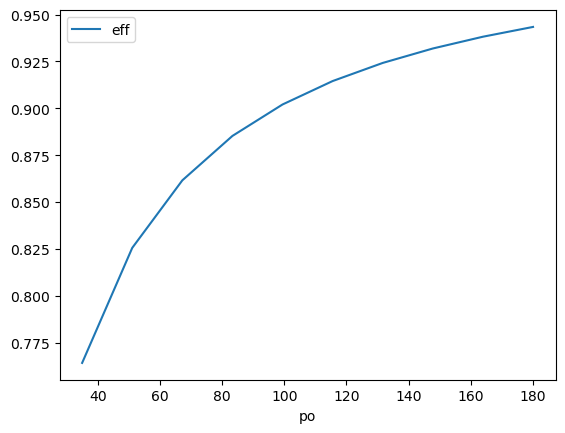

In [28]:
# plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df.plot(x='po', y='eff', ax=ax)

In [31]:
# define inductance range
Lo_range = [df['Lmin'].min(), df['Lmin'].max()]
print(Lo_range)



[5.911111111111111e-07, 2.6742857142857144e-06]


In [32]:
import PyMKF
import json
import pprint

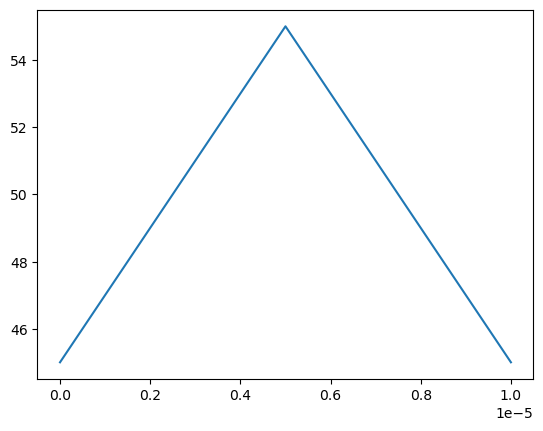

In [35]:
processed_waveform = {
    "offset": 50,
    "label": "Triangular",
    "peakToPeak": 50*0.2,
}

waveform = PyMKF.create_waveform(processed_waveform, fsw)

fig, ax = plt.subplots()
ax.plot(waveform['time'], waveform['data'])
plt.show()


In [38]:
from collections import defaultdict

# Function to create a nested defaultdict
def nested_dict():
    return defaultdict(nested_dict)


In [40]:
# Create the dynamic dictionary
inputs = nested_dict()
inputs["operatingPoints"][0]["excitationsPerWinding"][0] = {}
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["frequency"] = fsw
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["current"] = {}
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["current"]["waveform"] = waveform
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["voltage"] = PyMKF.calculate_induced_voltage(inputs["operatingPoints"][0]["excitationsPerWinding"][0], np.min(Lo_range))
inputs["operatingPoints"][0]["excitationsPerWinding"][1] = PyMKF.calculate_reflected_secondary(inputs["operatingPoints"][0]["excitationsPerWinding"][0], fsw)

In [43]:
magnetic = {}
mas_result = PyMKF.simulate(inputs, magnetic, {})
mas_result

"Exception: [json.exception.out_of_range.403] key 'coil' not found"

In [ ]:

pprint.pprint(f'Core losses at {fsw}: {mas_result["outputs"][0]["coreLosses"]["coreLosses"]}')
pprint.pprint(f'Winding losses at {fsw}: {mas_result["outputs"][0]["windingLosses"]["windingLosses"]}')